# 🌍 Weather Forecast Benchmarking in Africa  
**Using Observations, Satellite Products, and GraphCast AI Forecasts**

This tutorial guides you through a simple, reproducible pipeline to **evaluate weather forecasts in Africa** using:

- ✅ Ground **observation data** (e.g. rainfall from station measurements)
- 🛰️ Satellite-based **precipitation products** (e.g. IMERG)
- 🤖 AI-generated forecasts from **GraphCastGFS** (via NOAA/Google DeepMind)

### 📌 Why this matters
Accurate, timely forecasts are essential for agriculture, water management, disaster response, and climate resilience — especially in **data-sparse regions like Africa**. But modern AI and physics-based models are often not evaluated fairly or transparently on the continent.

### 📊 What you'll learn
- How to **harmonize** different datasets: observations, satellite, AI forecasts
- How to compute **core verification metrics**: RMSE, skill score, event-based scores (POD, FAR, CSI)
- How to compare **baseline vs GraphCast** at a ground station in Africa
- How to build a **simple leaderboard** of model skill

> 🔎 **Focus variable**: Total precipitation   
> 📍 **Focus region**: A point location in South Africa (station + surrounding satellite pixels)

Let's begin by setting up the data and tools.




<div style="display: flex; justify-content: space-around;">

  <div style="text-align: center;">
    <img src="../images/sa_station.png" alt="Weather Station" width="100"/>
    <p>🧍 Ground Station</p>
  </div>

  <div style="text-align: center;">
    <img src="../images/imerg.png" alt="IMERG Satellite" width="200"/>
    <p>🛰️ IMERG Satellite Product</p>
  </div>

  <div style="text-align: center;">
    <img src="../images/graphcast.png" alt="GraphCast Forecast" width="230"/>
    <p>🤖 GraphCast AI Forecast</p>
  </div>

</div>


## AfriNet observation data

In [1]:
import pandas as pd
# Load the South Africa weather station data
# The data is read from a CSV file hosted on Google Cloud Storage
df_afrinet=pd.read_csv("https://storage.googleapis.com/afrinet/daily-data/AfriNet002.csv")
df_afrinet.head(3)  # Display the first 3 rows of the DataFrame

,Unnamed: 0,time,temperature,feels_like,app_temp,dew_point,humidity,wind_direction,wind_speed,wind_gust,pressure_relative,pressure_absolute,rainfall
0,0,2024-11-20,24.312500,24.31250,24.625000,10.975000,43.250000,98.625000,0.000000,0.000000,29.918750,28.048750,0.0
1,1,2024-11-21,27.812500,28.40625,30.000000,17.235417,53.312500,100.979167,0.987500,2.310417,29.886667,28.017292,0.3
2,2,2024-11-22,28.069565,28.58913,30.317391,17.471739,54.891304,164.717391,1.102174,2.830435,29.832391,27.962609,0.0


In [2]:
# look up AfriNet metafile to extract the station coordinates
df_meta=pd.read_csv("https://storage.googleapis.com/afrinet/raw-data/AfriNet_metadata.csv")
df_meta

,Unnamed: 0,station_id,maintainer,latitude,longitude,altitude_m,country,network
0,0,AfriNet002,RM,-22.2921,30.8219,195.0,South Africa,AfriNet
1,1,AfriNet003,SA,36.6000,2.7000,168.0,Algeria,AfriNet
2,2,AfriNet001,AR,34.0000,10.0000,40.0,Tunisia,AfriNet
3,3,AfriNet004,AS,30.0000,31.0000,NaN,Egypt,AfriNet
4,4,AfriNet005,JT,-1.2000,36.8000,NaN,Kenya,AfriNet
5,5,AfriNet006,AM,37.1000,10.0300,NaN,Tunisia,AfriNet
6,6,Afrinet007,MD,14.7000,-17.0000,NaN,Senegal,AfriNet


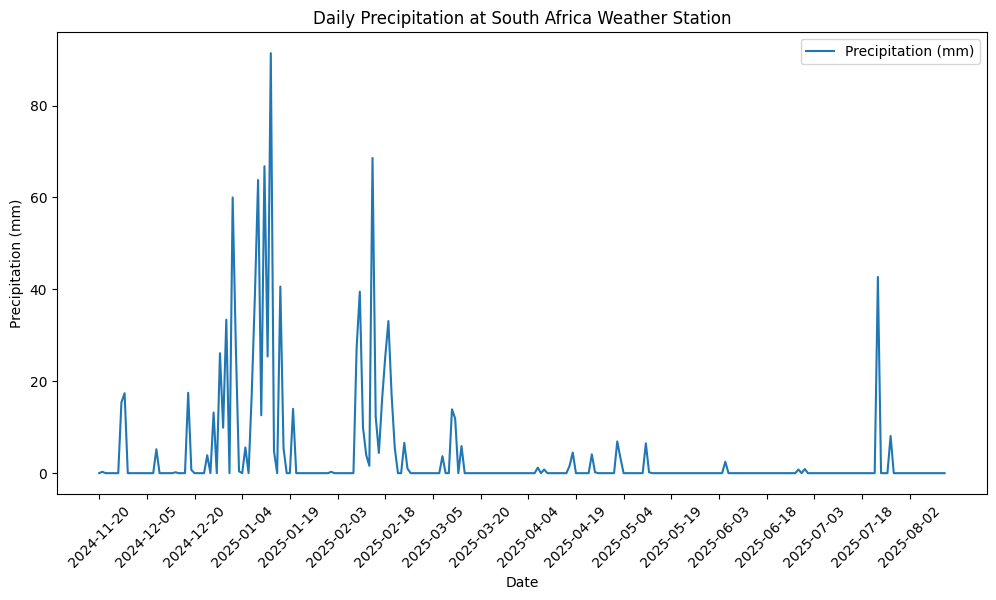

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_afrinet['time'].values, df_afrinet['rainfall'].values, label='Precipitation (mm)')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Daily Precipitation at South Africa Weather Station')
plt.xticks(rotation=45)
plt.xticks(df_afrinet['time'][::15], rotation=45)
plt.legend()
plt.show()

In [ ]:
#exercice
#compute the total monthly and compare to national average

##  Satellite Product: IMERG Daily Merged (V07B)


###  What IMERG Offers
IMERG merges data from multiple satellite sensors and radar to produce a globally consistent, gridded precipitation dataset. Key features include:
- **Temporal coverage**: Half-hourly data from ~June 2000 onward; this is **daily aggregated** output.
- **Spatial resolution**: ~0.25° X 0.25° (~25 km) global grid.
- **Version**: V07B (latest, with improved accuracy, lower RMSE than previous versions).

###  File Naming Convention Breakdown

- `3B-DAY` → Daily aggregated product  
- `MS.MRG.3IMERG` → “Merged Sounding” IMERG method  
- `YYYYMMDD` → Date (e.g. `20220101`)  
- `S000000‑E235959` → Valid from 00:00 to 23:59 (UTC)  
- `V07B` → Version identifier  
- `_SouthAfrica` → Regional subset (within a Hugging Face dataset)

###  Format & Practical Details
- **File format**: NetCDF4 (`.nc4`), leveraging the HDF5 backbone. :contentReference[oaicite:4]{index=4}  
- **Typical file size**: ~25–33 MB for a daily global file. :contentReference[oaicite:5]{index=5}  
- Contains:
  - 2D precipitation fields (daily total)
  - Metadata: time coverage, lat/lon grid, data source, etc.

###  Why It’s Useful in Benchmarking
- **High-quality satellite benchmark**: Satellite-derived daily precipitation offers a crucial bridge between sparse observations and AI forecasts.  
- **Resolution complementarity**: IMERG’s ~0.1° grid is well-suited for country-level comparisons in Africa.  
- **Temporal alignment**: Daily aggregation makes it easy to compare IMERG against station data and GraphCast outputs spanning multiple days.

---

This product lets us compare **ground truth**, **satellite-merged observations**, and **AI forecasts**—all on the same daily timescale and spatial footprint over regions like South Africa.




### Loading the dataset from HF

In [7]:
!pip install netcdf4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.3 MB/s eta 0:00:00


In [9]:

import fsspec
from itertools import islice
import time
import xarray as xr
def load_imerg_from_HF(subdir = "SouthAfrica",token=None):
    repo_id = "musamthembu84/imerg"
    #SouthAfrica_Limpopo/3B-DAY-L.MS.MRG.3IMERG.20250331-S000000-E235959.V07B_SouthAfrica_Limpopo.nc4
    pattern = f"hf://datasets/{repo_id}/{subdir}/*.nc4"
    files = fsspec.open_files(pattern, mode="rb",token=token)


    # Helper to split files into batches
    def _batch_iterable(iterable, size):
        it = iter(iterable)
        while batch := list(islice(it, size)):
            yield batch

    batch_size = 20
    datasets = []

    for batch_files in _batch_iterable(files, batch_size):
        file_objs = []
        for f in batch_files:
            try:
                file_objs.append(f.open())
                time.sleep(0.2)  # <-- gentle delay to reduce HF rate-limit
            except Exception as e:
                print(f"Failed to open {f}: {e}, retrying after 1s")
                time.sleep(1)
                file_objs.append(f.open())

        # Lazy-load with dask, combine by coords
        ds_batch = xr.open_mfdataset(
            file_objs,
            engine="scipy",
            combine="by_coords",
            parallel=True,
            chunks={"time": 50},  # small chunks keeps memory usage low
        )
        datasets.append(ds_batch["precipitation"])
        print(f"Processed batch of {len(batch_files)} files, total batches: {len(datasets)}")

    # Concatenate all batches along time
    ds = xr.concat(datasets, dim="time")

    return ds
precip_ds= load_imerg_from_HF(token="")

Processed batch of 20 files, total batches: 1
Processed batch of 20 files, total batches: 2
Processed batch of 20 files, total batches: 3
Processed batch of 20 files, total batches: 4
Processed batch of 20 files, total batches: 5
Processed batch of 20 files, total batches: 6
Processed batch of 20 files, total batches: 7
Processed batch of 20 files, total batches: 8
Processed batch of 20 files, total batches: 9
Processed batch of 20 files, total batches: 10
Processed batch of 20 files, total batches: 11
Processed batch of 20 files, total batches: 12
Processed batch of 20 files, total batches: 13
Processed batch of 20 files, total batches: 14
Processed batch of 20 files, total batches: 15
Processed batch of 20 files, total batches: 16
Processed batch of 20 files, total batches: 17
Processed batch of 20 files, total batches: 18
Processed batch of 20 files, total batches: 19
Processed batch of 20 files, total batches: 20
Processed batch of 20 files, total batches: 21
Processed batch of 20 

In [ ]:
precip_ds.sel(time=slice("2025-01-01", "2025-08-01")).to_netcdf("tp_2025.nc")

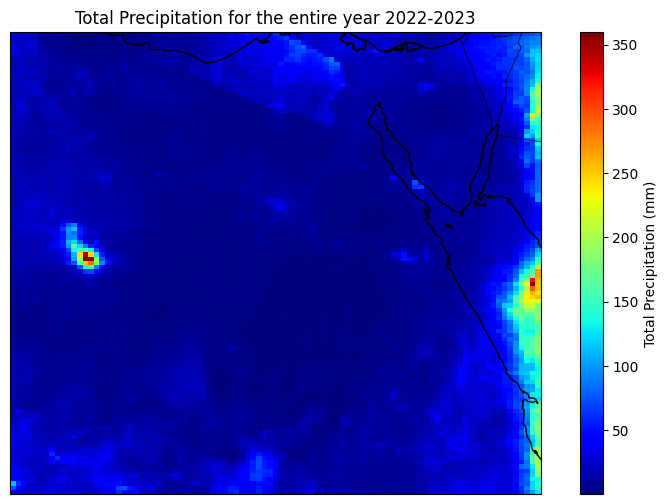

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm
import numpy as np
# Select data for 2018
#"2022-08-01","2022-12-01","2023-03-01",
for end_date in ["2024-12-01"]:
    ds_2018 = precip_ds.sel(time=slice("2024-01-01", end_date))

    # Sum precipitation over time (resulting shape: lat x lon)
    total_precip = ds_2018.sum(dim='time')

    # Get coordinates
    lons = precip_ds.lon.values
    lats = precip_ds.lat.values

    # Get extent for imshow (left, right, bottom, top)
    extent = [lons.min(), lons.max(), lats.min(), lats.max()]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    img = ax.imshow(
        total_precip.values,
        extent=extent,
        origin='lower',
        cmap='jet',

        interpolation='none',
    )

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title("Total Precipitation for the entire year 2022-2023")
    plt.colorbar(img, ax=ax, label='Total Precipitation (mm)')
    plt.show()
    plt.close(fig)


In [ ]:
afrinet2_lat= 22.983967 # latitude of AfriNet002 station
afrinet2_lon=  30.457111  # longitude of AfriNet002 station
step=0.25

afrinet_imerg = precip_ds.sel(
    lat=slice(afrinet2_lat - step, afrinet2_lat + step),  # reversed
    lon=slice(afrinet2_lon - step, afrinet2_lon + step)   # ascending as usual
)
afrinet_imerg.shape

(1186, 5, 5)

In [ ]:
#todo draw extracted region on previous map

In [ ]:
region_total = afrinet_imerg.sum(dim=["lat", "lon"])
df_imerg=region_total.to_dataframe()

In [ ]:
import pandas as pd
df_imerg.index=pd.to_datetime(df_imerg.index)
df_afrinet.time=pd.to_datetime(df_afrinet.time)

In [ ]:
from DLI25.utils import resample_to_daily
df_afrinet=resample_to_daily(df_afrinet, "rainfall", time_col='time', new_col_name=None)
df_imerg=resample_to_daily(df_imerg, "precipitation", time_is_index=True, new_col_name=None)


In [ ]:
df_afrinet

,time,rainfall
0,2024-11-20,0.0
1,2024-11-21,0.3
2,2024-11-22,0.0
3,2024-11-23,0.0
4,2024-11-24,0.0
...,...,...
262,2025-08-09,0.0
263,2025-08-10,0.0
264,2025-08-11,0.0
265,2025-08-12,0.0


In [ ]:
merged_df = df_imerg.merge(df_afrinet, on='time', how='inner')
merged_df=merged_df[merged_df.time>"2024-11-01"]

In [ ]:
merged_df

,time,precipitation,rainfall
0,2024-11-20,0.000,0.0
1,2024-11-21,0.235,0.3
2,2024-11-22,0.000,0.0
3,2024-11-23,0.000,0.0
4,2024-11-24,0.000,0.0
...,...,...,...
127,2025-03-27,6.855,0.0
128,2025-03-28,2.035,0.0
129,2025-03-29,0.000,0.0
130,2025-03-30,0.075,0.0


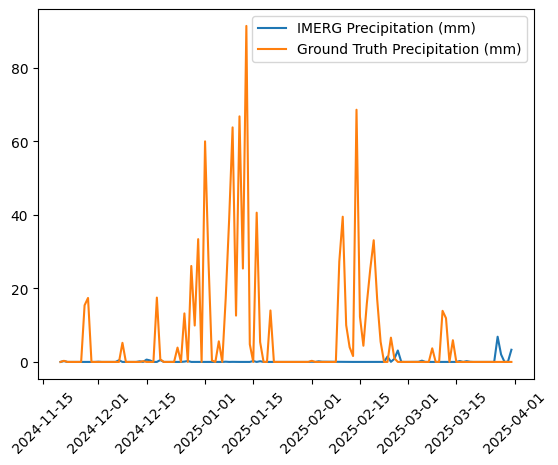

In [ ]:
plt.plot(merged_df.time.values, merged_df['precipitation'].values, label='IMERG Precipitation (mm)')
plt.plot(merged_df.time.values, merged_df['rainfall'].values, label='Ground Truth Precipitation (mm)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# todo show IMERG vs Afrinet data
# aggregate
# select IMERG region around the station
# compare with Afrinet data

## 🤖 GraphCastGFS Forecasts from NOAA

**GraphCastGFS** is an experimental AI-powered global weather forecast dataset developed by **NOAA** and **Google DeepMind**, made publicly available through NOAA's **Open Data Dissemination (NODD)** on AWS.

It provides **medium-range deterministic forecasts** using a machine-learned model trained to emulate and outperform traditional physics-based systems like GFS.

### 📦 Dataset Overview
- **Forecast Model**: [GraphCast](https://deepmind.google/discover/blog/graphcast-ai-model-for-faster-and-more-accurate-global-weather-forecasting/)
- **Publisher**: NOAA's Project Eagle (via [NWS GraphCastGFS PDS](https://registry.opendata.aws/noaa-nws-graphcastgfs-pds/))
- **Forecast Range**: up to **16 days** (384 hours), hourly steps
- **Update Frequency**: Twice daily at **00Z** and **06Z**
- **Resolution**: 0.25° × 0.25° global grid (~25 km)
- **Format**: GRIB2 (`.grb2`) files with accompanying index files (`.idx`)

### 🧾 File Naming Convention

Each forecast file follows this pattern:


graphcastgfs.t{HH}z.pgrb2.0p25.f{HHH}


- `t{HH}z` → Model run hour (e.g. `t00z`, `t06z`)
- `pgrb2.0p25` → GRIB2 file at 0.25° resolution
- `f{HHH}` → Forecast hour (e.g. `f000` = analysis, `f144` = +6 days)

> 🔁 Example: `graphcastgfs.t06z.pgrb2.0p25.f144`  
> Means: Forecast initialized at 06Z, valid at hour 144 (+6 days)

### 🌐 Variables (Fields Available)
GraphCastGFS provides key surface and upper-air variables, including:
- `prate` – Precipitation rate (kg/m²/s)
- `tmp` – Temperature (2m, 850 hPa, 500 hPa, etc.)
- `ugrd`, `vgrd` – Wind components (10m, 250 hPa, etc.)
- `gh` – Geopotential height (500 hPa)
- `rh` – Relative humidity
- `tcdc` – Total cloud cover
- `ps`, `mslet` – Surface pressure fields

These variables are stored at multiple vertical levels or surface layers and are indexed for efficient access.

---

GraphCastGFS allows us to benchmark **AI weather forecasts** in Africa against both **satellite products (IMERG)** and **ground station observations**, helping assess the real-world skill of modern models in data-sparse regions.


In [ ]:
#todo
# load forecast data from the Graphcast dataset for january 2025
# store the forecast in a gc bucket so participants can access it
# use noaa link

#https://noaa-nws-graphcastgfs-pds.s3.amazonaws.com/index.html#graphcastgfs.20250101/06/forecasts_13_levels/

In [ ]:
#!pip install cfgrib
# or
#conda install -c conda-forge cfgrib


In [ ]:
import xarray as xr
print('cfgrib' in xr.backends.list_engines())

True


In [ ]:
import xarray as xr
import requests

# Wrap the URL with `simplecache` to download to local cache transparently
#local_file = "/Users/amrouche/Downloads/graphcastgfs.t06z.pgrb2.0p25.f018"
local_file="graphcast_jan/01/graphcastgfs.t06z.pgrb2.0p25.f000"

import glob


ds = xr.open_dataset(
    local_file,
        engine="cfgrib",


)


skipping variable: paramId==167 shortName='t2m'
Traceback (most recent call last):
  File "/Users/amrouche/.pyenv/versions/3.10.13/lib/python3.10/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/amrouche/.pyenv/versions/3.10.13/lib/python3.10/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=np.float64(10.0)) new_value=Variable(dimensions=(), data=np.float64(2.0))
/Users/amrouche/.pyenv/versions/3.10.13/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [ ]:
import matplotlib.pyplot as plt
africa = ds.tp.sel(
    latitude=slice(35, -35),     # North to South (may be reversed depending on dataset)
    longitude=slice(-20, 55)     # West to East
)

# Select first time step if time dimension exists
if 'time' in africa.dims:
    africa = africa.isel(time=0)

# Plot
africa.plot(cmap="Blues", figsize=(10, 6))
plt.title("Total Precipitation over Africa")
plt.show()

AttributeError: 'Dataset' object has no attribute 'tp'

In [ ]:
# Define your box boundaries (± margin)
lat_margin = 0.25 *2
lon_margin = 0.25 *2

lat = -22.983967
lon = 30.457111

lat_min = lat - lat_margin
lat_max = lat + lat_margin
lon_min = lon - lon_margin
lon_max = lon + lon_margin

# Subset the dataset
ds_box = ds.sel(
    latitude=slice(lat_max, lat_min),  # ↓ south, so max to min
    longitude=slice(lon_min, lon_max)
)


SA_station=ds.sel(latitude=-22, longitude=30, method="nearest")


In [ ]:
SA_station.tp.values

array(0.04355621, dtype=float32)